# Applicatoin of Custom Loss function
This notebook demostrates the steps on how to implement and modify a custom loss function for our autoencoder
First, the autoencoder and the data is imported. We both consider training a new AE from scratch and training on top of an laready trained one.

In [2]:
from FlowCompression import AE
import tensorflow as tf
u_train, u_val, u_test = AE.preprocess()
new_ae = AE()
new_ae.u_train, new_ae.u_val, new_ae.u_test = u_train, u_val, u_test

already_trained_ae = AE.create_trained(1)
already_trained_ae.u_train, already_trained_ae.u_val, already_trained_ae.u_test = u_train, u_val, u_test


Then we define our loss function with the accompanying functions
This function can also be imported from CustomKeras by
from FlowCompression import custom_loss_function
Also the custom loss function should be changed here if you want to experiment.

In [3]:
def central_difference(before, after):
    return tf.math.scalar_mul(0.5, tf.math.subtract(after, before))


def forward_difference(current, after):
    return tf.math.subtract(after, current)


def backward_difference(before, current):
    return tf.math.subtract(current, before)


def one_gradient(kxnxn, i, j, axis):
    if axis == 0:
        if i == 0:
            return forward_difference(kxnxn[:, i + 1, j], kxnxn[:, i, j])
        elif i == 23:
            return backward_difference(kxnxn[:, i, j], kxnxn[:, i - 1, j])
        else:
            return central_difference(kxnxn[:, i + 1, j], kxnxn[:, i - 1, j])
    elif axis == 1:
        if j == 0:
            return forward_difference(kxnxn[:, i, j + 1], kxnxn[:, i, j])
        elif j == 23:
            return backward_difference(kxnxn[:, i, j], kxnxn[:, i, j - 1])
        else:
            return central_difference(kxnxn[:, i, j + 1], kxnxn[:, i, j - 1])
    else:
        raise NotImplementedError


@tf.function
def custom_gradient(kxnxn, axis):
    n = 24
    return tf.transpose([[one_gradient(kxnxn, i, j, axis=axis) for i in range(n)] for j in range(n)], (2, 0, 1))


def custom_loss_function(y_true, y_pred):
    u_true = y_true[:, :, :, 0]
    v_true = y_true[:, :, :, 1]
    u_pred = y_pred[:, :, :, 0]
    v_pred = y_pred[:, :, :, 1]

    energy_true = tf.math.add(tf.multiply(u_true, u_true), (tf.multiply(v_true, v_true)))
    energy_pred = tf.math.add(tf.multiply(u_pred, u_pred), (tf.multiply(v_pred, v_pred)))

    energy_difference = tf.math.reduce_mean(tf.math.squared_difference(energy_true, energy_pred), axis=[1, 2])

    curl_true = tf.math.subtract(custom_gradient(u_true, axis=1), custom_gradient(v_true, axis=0))
    curl_pred = tf.math.subtract(custom_gradient(u_pred, axis=1), custom_gradient(v_pred, axis=0))

    curl_difference = tf.math.reduce_mean(tf.math.squared_difference(curl_true, curl_pred), axis=[1, 2])

    divergence = tf.math.abs(
        tf.math.reduce_mean(tf.math.add(custom_gradient(u_pred, axis=0), custom_gradient(v_pred, axis=1)), axis=[1, 2]))

    u_mse = tf.math.reduce_mean(tf.math.squared_difference(u_true, u_pred), axis=[1, 2])
    v_mse = tf.math.reduce_mean(tf.math.squared_difference(v_true, v_pred), axis=[1, 2])

    return energy_difference, curl_difference, divergence

This function has a batch of original and reconstructed images as an input and should give an output of a tuple of arrays of scalars, with each scalar corresponing to one reconstructed image. 

First, lets set up the new AE with the custom loss with low epochs to speed it up. The model need to be recompiled with the new loss function

In [7]:
from keras.optimizers import Adam

new_ae.epochs = 10
new_ae.batch = 10
new_ae.l_rate = 0.001
new_ae.autoencoder.compile(optimizer=Adam(learning_rate=new_ae.l_rate), loss=custom_loss_function)

Then we need to run the training

In [8]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=new_ae.early_stopping)


new_ae.hist = new_ae.autoencoder.fit(new_ae.u_train, new_ae.u_train, epochs=new_ae.epochs, batch_size=new_ae.batch,
                                         shuffle=False, validation_data=(new_ae.u_val, new_ae.u_val),
                                         verbose=1,
                                         callbacks=[early_stop_callback])


Epoch 1/10
300/300 [==============================] - 66s 138ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 2/10
300/300 [==============================] - 43s 144ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/10
300/300 [==============================] - 43s 143ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 4/10
300/300 [==============================] - 42s 139ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 5/10
300/300 [==============================] - 42s 140ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/10
300/300 [==============================] - 43s 142ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 7/10
300/300 [==============================] - 42s 140ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/10
300/300 [==============================] - 44s 146ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 9/10
300/300 [==============================] - 42s 140ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 10/10
300/300 [==============================] - 42s 140ms/step - l

Let's see the performance of the newly trained model!

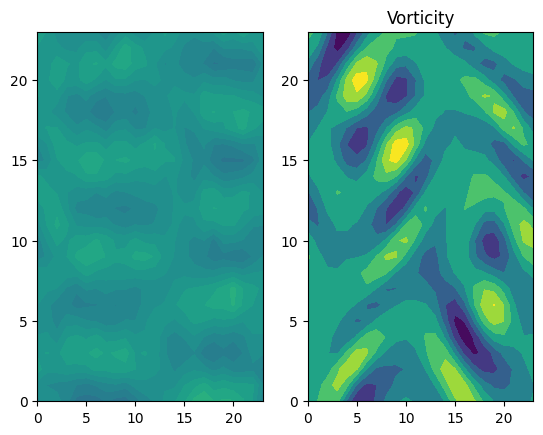

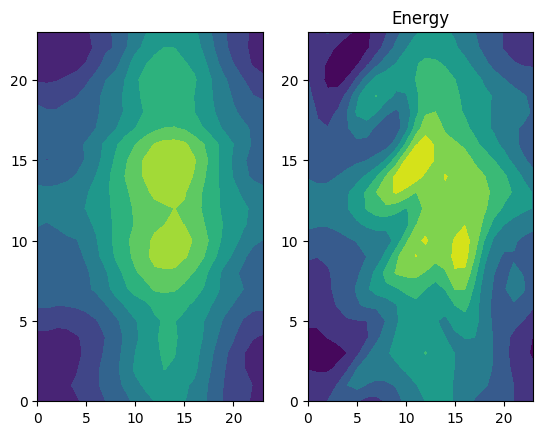

max: 0.3381669521331787
min: -2.0029296875
avg: -0.36916595697402954
max: 0.6494913101196289
min: -0.5732858180999756
avg: 0.09687959402799606
Absolute %: 90.334 +- 4.861999988555908
Squared %: 99.139 +- 1.0820000171661377


In [10]:
t = new_ae.passthrough(u_test) # generates predictions on unseen data
new_ae.vorticity_energy() # plots vorticity and energy, left the reconstructed, right the original
perf = new_ae.performance() # calculates performance

new_ae.verification(u_test) # prints the divergence values of the original
new_ae.verification(new_ae.y_pred) # and the reconstructed flow

print(f'Absolute %: {round(perf["abs_percentage"], 3)} +- {round(perf["abs_std"], 3)}') # prints accuracy in absolute error
print(f'Squared %: {round(perf["sqr_percentage"], 3)} +- {round(perf["sqr_std"], 3)}') # and in MSE


We can see on these plots and on the divergence in the validation, that the loss functions do train the AE in the right direction. However, unfortunately it seems to be stuck in too many local minimuns. Therefore we also experimented with traning with the custom loss functions on top of the already trained model. In this case the weights have to be saved and reset after the compiling, becasue while recompiling the weights are lost.

In [13]:
already_trained_ae.epochs = 5
already_trained_ae.batch = 10
already_trained_ae.l_rate = 0.00001
weights = already_trained_ae.autoencoder.get_weights()
already_trained_ae.autoencoder.compile(optimizer=Adam(learning_rate=already_trained_ae.l_rate), loss=custom_loss_function)
already_trained_ae.autoencoder.set_weights(weights)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=already_trained_ae.early_stopping)


already_trained_ae.hist = already_trained_ae.autoencoder.fit(already_trained_ae.u_train, already_trained_ae.u_train, epochs=already_trained_ae.epochs,
                                         batch_size=already_trained_ae.batch,
                                         shuffle=False, validation_data=(already_trained_ae.u_val, already_trained_ae.u_val),
                                         verbose=1,
                                         callbacks=[early_stop_callback])

Epoch 1/5
300/300 [==============================] - 82s 194ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 2/5
300/300 [==============================] - 48s 161ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 3/5
300/300 [==============================] - 48s 160ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 4/5
300/300 [==============================] - 48s 159ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 5/5
300/300 [==============================] - 48s 158ms/step - loss: 0.0023 - val_loss: 0.0024


Once again, we can check the peroformance

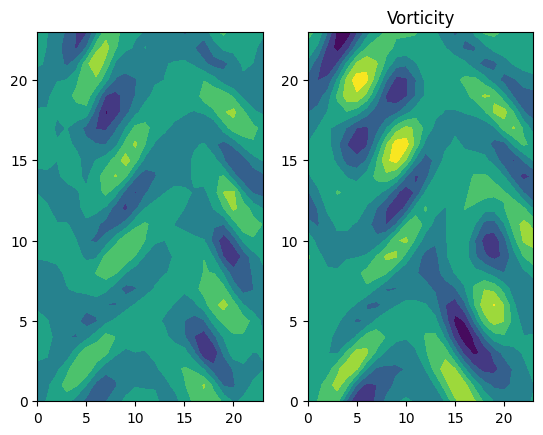

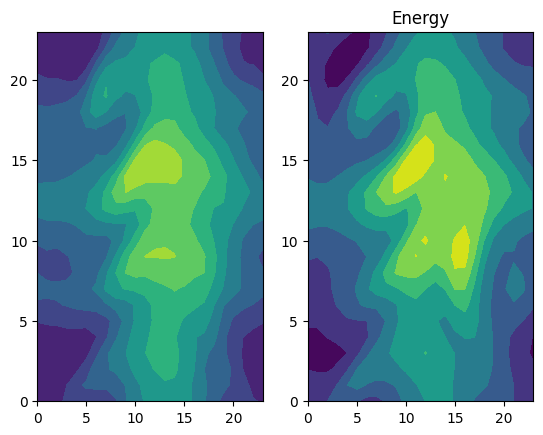

max: 0.3381669521331787
min: -2.0029296875
avg: -0.36916595697402954
max: 0.09415006637573242
min: -1.3950846195220947
avg: -0.6133828163146973
Absolute %: 90.334 +- 4.861999988555908
Squared %: 99.139 +- 1.0820000171661377


In [15]:
t = already_trained_ae.passthrough(u_test) # generates predictions on unseen data
already_trained_ae.vorticity_energy() # plots vorticity and energy, left the reconstructed, right the original
perf = new_ae.performance() # calculates performance

already_trained_ae.verification(u_test) # prints the divergence values of the original
already_trained_ae.verification(already_trained_ae.y_pred) # and the reconstructed flow

print(f'Absolute %: {round(perf["abs_percentage"], 3)} +- {round(perf["abs_std"], 3)}') # prints accuracy in absolute error
print(f'Squared %: {round(perf["sqr_percentage"], 3)} +- {round(perf["sqr_std"], 3)}') # and in MSE